Notebook with tests for checking the gebco bathymetry in canadian region. 

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc4
import matplotlib.pyplot as plt
import os
try:
    os.chdir(os.path.join(os.getcwd(),'bathymetry_checks') )# 
    print(os.getcwd())
except:
    pass

In [ ]:
ncfile='bathymetry_checks/gebco_2020_tid_n63.017578125000014_s56.865234375000014_w-71.71875_e-63.28125.nc'
ncdata=nc4.Dataset(ncfile)
lon=ncdata.variables['lon']
lat=ncdata.variables['lat']
tid=ncdata.variables['tid']
print(ncdata)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.PlateCarree()) 
ax.set_extent([-160,-40,45,90]) 
# ax.set_extent([-180,180,45,90])  
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature)

# plt.scatter(lon,lat,c=tid,transform=ccrs.PlateCarree())
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(tid[:]).T
df.to_excel(excel_writer = "tid.xlsx")

In [ ]:
plt.imshow(np.array(tid[:]))
plt.colorbar()


It seems that arctic grid is from IBCAO os I took IBCAOv4 and read the SID and TID grid


In [ ]:
sncfile='bathymetry_checks/IBCAO_v4_1_200m_SID.nc'
ncdata=nc4.Dataset(sncfile)
lon=ncdata.variables['x']
lat=ncdata.variables['y']
sid=ncdata.variables['z']
print(ncdata)

In [ ]:
plt.imshow(sid)
plt.colorbar()

In [ ]:
tncfile='bathymetry_checks/IBCAO_v4_1_200m_TID.nc'
ncdata=nc4.Dataset(tncfile)
lon=ncdata.variables['x']
lat=ncdata.variables['y']
tid=ncdata.variables['z']
print(ncdata)

In [ ]:
plt.imshow(tid)
plt.colorbar()

Turns out canadian region is covered by Nonna-100 of canadian hydrological service. they have their vertical datum as Lower low water large tide (LLWT). To understand how this datum is wrt to MSL datum. We take tide gauge data from the CHS portal. Here is the portal https://www.qc.dfo-mpo.gc.ca/tides/en/stations Which uses an api given as https://www.qc.dfo-mpo.gc.ca/tides/en/web-services-offered-canadian-hydrographic-service#currents This api uses curl to download files which give waterlevels in .json formats. More details on the functions to read can be seen in readchsdata.py

In [ ]:
#just a nice function to convert decimal degrees to minutes.
def decdeg2dms(dd):
    negative = dd < 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    if negative:
        if degrees > 0:
            degrees = -degrees
        elif minutes > 0:
            minutes = -minutes
        else:
            seconds = -seconds
    return (degrees,minutes,seconds)

In [35]:
# reading chs station metadata
import readchsdata
stationjsonfile='chsstations.json'
(allstationinfodata,stationamevec,stationidvec,stationlonvec,stationlatvec)=readchsdata.getallstationmetadata(stationjsonfile)

# computing the yearly mean of waterlevel at those stations.
sshmeanvec=[];Lon=[];Lat=[];namevec=[]
sshdata={}
for i in range(len(stationidvec)):
    stationname=stationamevec[i]
    fname='CHSdata/'+stationname+'.wl'
    # print(fname)
    if os.path.exists(fname):
        wldatatxt = np.loadtxt(fname,dtype='str',skiprows=2)
        # timedatnum=np.array((date2num(wldatatxt[:,0]))).flatten()
        sshi=wldatatxt[:,1].astype(np.float64)
        sshimean=sshi.mean()
        sshmeanvec=np.append(sshmeanvec,sshimean)
        Lon=np.append(Lon,[stationlonvec[i]])
        Lat=np.append(Lat,[stationlatvec[i]])
        namevec=np.append(namevec,stationname)
    else:
        print(fname)
sshdata={'Lon':Lon,'Lat':Lat,'Stationname':namevec,'hmean':sshmeanvec}


CHSdata/Diana Bay.wl
CHSdata/Flaherty Island.wl
CHSdata/GUYSBOROUGH.wl
CHSdata/Roberts Bay.wl
CHSdata/High Island.wl
CHSdata/Glendale Cove.wl
CHSdata/Quadyuk Island.wl
CHSdata/Sedgwick Bay.wl
CHSdata/Kean Point.wl
CHSdata/Shields Bay.wl
CHSdata/Fox Islands.wl
CHSdata/Port Leopold.wl
CHSdata/Nuuk.wl
CHSdata/Thank God Harbour.wl
CHSdata/TERRENCEVILLE.wl
CHSdata/SOUTH EAST BIGHT.wl
CHSdata/BRANCH.wl
CHSdata/MEMRAMCOOK.wl
CHSdata/Tanquary Camp.wl
CHSdata/Edward Channel.wl
CHSdata/GLACE BAY.wl
CHSdata/ST ANNS HARBOUR.wl
CHSdata/WEYMOUTH.wl
CHSdata/Roberts Bank.wl
CHSdata/RENCONTRE WEST.wl
CHSdata/Kleybolte Peninsula.wl
CHSdata/WILD COVE.wl
CHSdata/Ogdensburg.wl
CHSdata/CONNOIRE BAY.wl
CHSdata/WINDSOR.wl
CHSdata/Entrance Island.wl
CHSdata/Foulke Harbour.wl
CHSdata/Butedale.wl
CHSdata/Meyers Narrows.wl
CHSdata/RAYMOND POINT.wl
CHSdata/Cape Liverpool.wl
CHSdata/North Star Bay.wl
CHSdata/Aulatsivik Point.wl
CHSdata/Rensselaer Bay.wl
CHSdata/Brooksby Point.wl
CHSdata/Baychimo.wl
CHSdata/Borrowma

In [40]:
def snap2canadagrid(posvec,value,quad):
    npos=np.zeros((2,1))
    nval=[]
    for i in range(len(posvec[:,0])):
        if (quad[0]<=posvec[i,0]<=quad[1]) and (quad[2]<=posvec[i,1]<=quad[3]): 
            npos=np.append(npos,[[posvec[i,0]],[posvec[i,1]]],axis=1)
            nval=np.append(nval,value[i])
    npos=npos[:,1:].T
    return(npos,nval)

In [41]:
##snapping to our regional model canada grid.
import sys
sys.path.append('../')
from postprocessing import readdata
quad1=[-150.0,-100.0,65.0,83.21]  #quad=[lon1,lon2,lat1,lat2]
quad2=[-100.0,-72.0,50.0,83.21]
quad3=[-72.0,-47.1,52.65,83.21] 
slonlatvec=np.vstack((sshdata['Lon'],sshdata['Lat'])).T
(nslonlatvec1,snamevec1)=snap2canadagrid(slonlatvec,sshdata['Stationname'],quad1)
(nslonlatvec2,snamevec2)=snap2canadagrid(slonlatvec,sshdata['Stationname'],quad2)
(nslonlatvec3,snamevec3)=snap2canadagrid(slonlatvec,sshdata['Stationname'],quad3)
nslonlatvec=np.vstack((nslonlatvec1,nslonlatvec2,nslonlatvec3))
snamevec=np.concatenate((snamevec1,snamevec2,snamevec3),axis=None)
(nslonlatvec1,shmeanvec1)=snap2canadagrid(slonlatvec,sshdata['hmean'],quad1)
(nslonlatvec2,shmeanvec2)=snap2canadagrid(slonlatvec,sshdata['hmean'],quad2)
(nslonlatvec3,shmeanvec3)=snap2canadagrid(slonlatvec,sshdata['hmean'],quad3)
nslonlatvec=np.vstack((nslonlatvec1,nslonlatvec2,nslonlatvec3))
shmeanvec=np.concatenate((shmeanvec1,shmeanvec2,shmeanvec3),axis=None)
# (slonlatvec,snamevec)=readdata.snappingcanadagrid(slonlatvec,sshdata['Stationname'],lon0,lon1,lon2,lat0,lat1,lat2)
# (slonlatvec,shmeanvec)=readdata.snappingcanadagrid(slonlatvec,sshdata['hmean'],lon0,lon1,lon2,lat0,lat1,lat2)

In [42]:
# reading the LAT MSL corrections from GTSM
xyzfile='LAT_DCSM_FES.xyz'
correctionarray = np.loadtxt(xyzfile,dtype='float')
np.shape(correctionarray)

(12368378, 3)

In [6]:
##eleminating NaN values
# nanarr=~np.isnan(correctionarray[:,2])
# correctionarrayn=-correctionarray[nanarr,:] #negative because the reference is below.
# print(np.shape(correctionarrayn))
# no use of removing nan

In [43]:
# allocs=np.vstack((correctionarrayn[:,0],correctionarrayn[:,1])).T
# corrval=correctionarrayn[:,2]
allocs=np.vstack((correctionarray[:,0],correctionarray[:,1])).T
print(np.shape(allocs))
corrval=-correctionarray[:,2] #negative because the reference is below.

(12368378, 2)


In [44]:
(scanlocs1,scorrval1)=snap2canadagrid(allocs,corrval,quad1)
(scanlocs2,scorrval2)=snap2canadagrid(allocs,corrval,quad2)
(scanlocs3,scorrval3)=snap2canadagrid(allocs,corrval,quad3)
scanlocs=np.vstack((scanlocs1,scanlocs2,scanlocs3))
scorrval=np.concatenate((scorrval1,scorrval2,scorrval3),axis=None)
triang=readdata.gettriangulation(scanlocs[:,0],scanlocs[:,1])

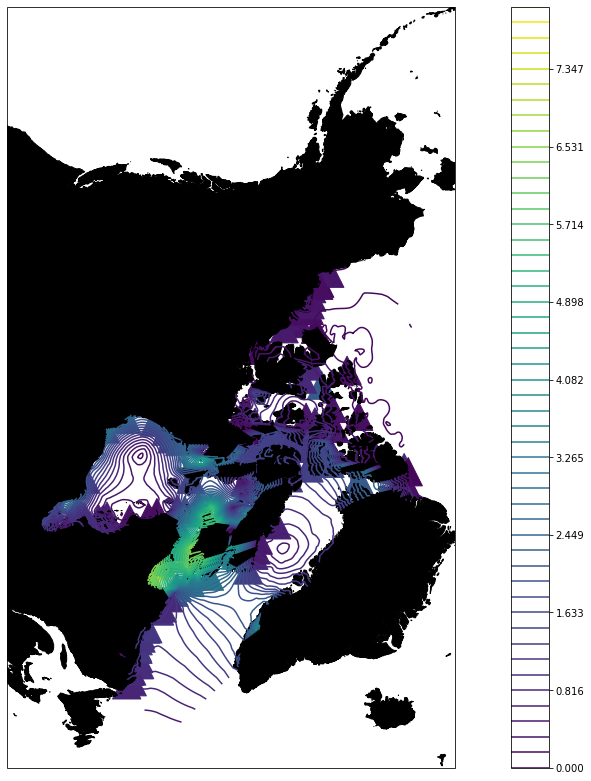

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
cbarlabel='Difference(LLWtmean-correction)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
contour_opts = {'levels': np.linspace(0,8,50),
                'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
cont=ax1.tricontour(triang,scorrval,**contour_opts)
fig.colorbar(cont)
cont1=ax1.scatter(nslonlatvec[:,0],nslonlatvec[:,1],c=shmeanvec,transform=ccrs.PlateCarree(),cmap='viridis',marker='^',s=800,vmin=0,vmax=8.0)
# cbar=fig.colorbar(cont,fraction=0.078, pad=0.04)
# cbar.set_label(cbarlabel, rotation=90, fontsize=18)
# cbar.ax.tick_params(labelsize=18)
plt.show()

In [45]:
# getting points which are nearby the station lon and lat
def getvicinitypoints(locations,sshval,lon1,lon2,lat1,lat2):  # 0 is left most or bottomost
    nlocations=np.zeros((2,1))
    nsshval=[]
    for i in range(len(locations[:,0])):
        if (lon1<=locations[i,0]<=lon2) and (lat1<=locations[i,1]<=lat2): 
            nlocations=np.append(nlocations,[[locations[i,0]],[locations[i,1]]],axis=1)
            nsshval=np.append(nsshval,sshval[i])
    nlocations=nlocations[:,1:].T
    # print(nobs.shape)
    # print(nobsname.shape)
    return(nlocations,nsshval)
from scipy.interpolate import NearestNDInterpolator   
    

In [47]:
diffvec=[]
nslonvec=[];nslatvec=[];nhmeanvec=[];nsnamevec=[]
for i in range(len(snamevec)):
    station=snamevec[i]
    slon=nslonlatvec[i,0];slat=nslonlatvec[i,1]
    stathmean=shmeanvec[i]
    dlon=0.2;dlat=0.1

    (nlocations,ncorrval)=getvicinitypoints(scanlocs,scorrval,slon-dlon,slon+dlon,slat-dlat,slat+dlat)
    try:
        interpolatefunc=NearestNDInterpolator(nlocations,ncorrval)
        stacorrval=interpolatefunc(slon,slat)
        difference=stathmean-stacorrval
        nslonvec=np.append(nslonvec,slon)
        nslatvec=np.append(nslatvec,slat)
        nhmeanvec=np.append(nhmeanvec,stathmean)
        nsnamevec=np.append(nsnamevec,snamevec[i])
        print(difference)
        diffvec=np.append(diffvec,difference)
    except (IndexError):
        print('Tide gauge in the interior land. Skipping it.')
        pass



-0.055041637112932584
0.018031334562841506
0.06910364125683055
-0.19567641734972677
Tide gauge in the interior land. Skipping it.
1.4964344933515479
0.10354858451730414
0.12692694203096533
-0.04950471493624775
-0.02379150500910754
0.2265696891165756
-0.11372361425318761
-0.23124321876138434
0.19711081352459026
0.09641179963570135
0.27353568665755923
0.11320874234972683
0.1353859947176685
0.28252157445355197
-0.03423323520036431
0.2571127040983606
-0.0074743956739526385
0.07429978073770493
Tide gauge in the interior land. Skipping it.
-0.08194655901639342
-0.03309992668488154
-0.0679628487704913
0.03622703529143889
-0.09399430464480862
0.008908082832422615
-0.5736319629781423
-0.1844227567850638
-0.013299723588342471
Tide gauge in the interior land. Skipping it.
-0.24611493278688523
Tide gauge in the interior land. Skipping it.
-0.24443528761384314
0.24247165810564664
0.09108366693989056
-0.34228333520036447
-0.5087663994080143
-0.10368752058287789
0.012840608788706298
-0.04056103037340

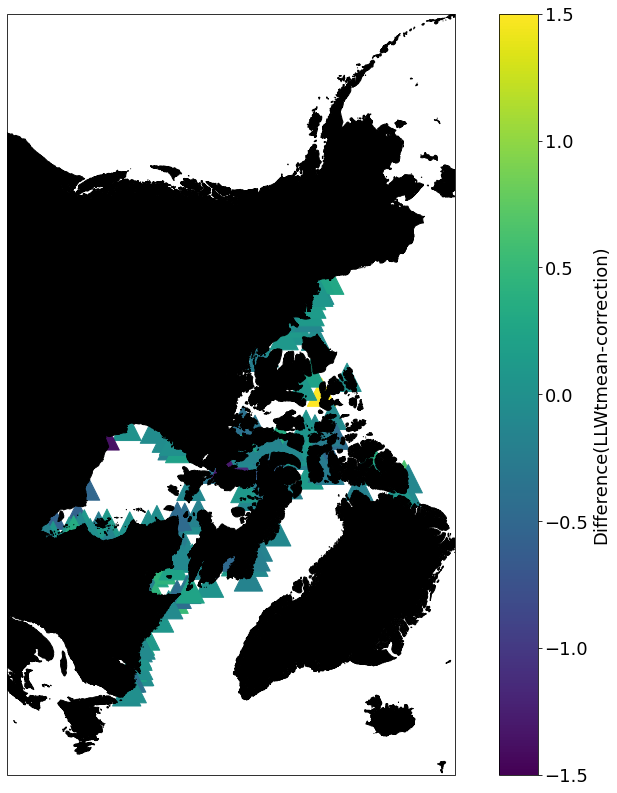

In [48]:
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
cbarlabel='Difference(LLWtmean-correction)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
cont1=ax1.scatter(nslonvec,nslatvec,c=diffvec,transform=ccrs.PlateCarree(),cmap='viridis',marker='^',s=800,vmin=-1.5,vmax=1.5)
cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.show()

In [12]:
bathncfile='gebco_2021_n83.0_s50.0_w-150.0_e-47.0.nc'
bathdata=nc4.Dataset(bathncfile)
lon=ncdata.variables['lon']
lat=ncdata.variables['lat']
Hb=ncdata.variables['elevation']
print(bathdata)

NameError: name 'ncdata' is not defined

Now we will get an interpolant to interpolate the bathymetry data to the tide gauge location and then compute dh/H i.e. the difference over bathymetry.

In [ ]:
from scipy.interpolate import interp2d
interpbath=interp2d(lon,lat,Hb)


In [ ]:
# the lon and lat coordinates are given in nslon and nslat
Hstation=[]
for i in range(len(diffvec)):
    Hi=interpbath(nslonvec[i],nslatvec[i])
    Hstation=np.append(Hstation,Hi)

In [19]:
# Hstation1=interpbath(nslonvec,nslatvec)
# print(np.shape(Hstation1))
# print(np.shape(Hstation))

(160, 160)
(160,)


In [22]:
print(Hstation)

[-1.50024000e+00  4.56632000e+00  4.74996000e+00 -1.83841162e+01
  6.42495600e+01 -7.50088000e+00  5.00080000e-01  1.37280000e+00
  1.95000000e+01  3.49960000e+00 -1.00000000e+00 -2.05400000e+01
  1.37673492e+00 -1.72511200e+01 -1.49976000e+00 -1.00000000e+00
  5.00000000e-01 -3.65810998e+00  2.49999994e-01  1.00016000e+00
  1.12496000e+01 -1.00000000e+00 -3.57564399e+01 -4.45689261e+00
 -5.80024800e+01 -1.69301560e+01 -6.25897741e-01  0.00000000e+00
 -1.50143994e-01  1.12491600e+01 -2.67548678e+00  0.00000000e+00
  1.83130962e+00  0.00000000e+00 -6.49920001e+00 -1.04615957e+01
  0.00000000e+00  2.24928001e+00  3.36205760e-01 -8.24872002e+00
 -1.22295996e+01 -2.25020000e+00  8.67361824e+00  0.00000000e+00
  9.56954995e+00 -2.00862400e+01 -1.00000000e+00  1.00000000e+01
 -2.24983999e+00 -4.24999999e+00  2.43616000e+00 -3.03918419e+01
  1.47500000e+01 -7.17687760e+01 -3.96200000e+01 -4.89984000e+00
  1.49976000e+00  1.57467867e+01 -2.04967200e+00 -1.65000800e+01
  8.86560000e+00 -4.26554

In [ ]:
Hstationmod=np.where(Hstation==0.0,0.01,Hstation)
dh_H=diffvec/Hstationmod

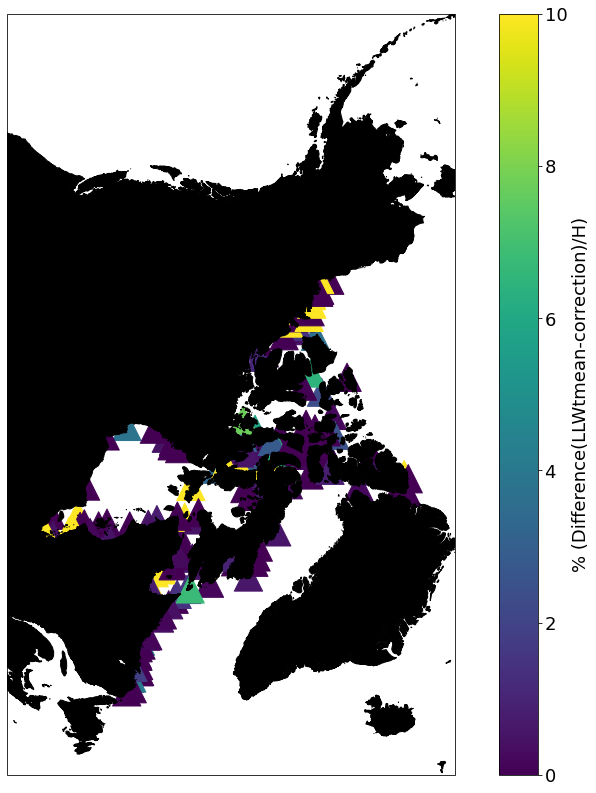

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
cbarlabel='% (Difference(LLWtmean-correction)/H)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
cont1=ax1.scatter(nslonvec,nslatvec,c=dh_H*100.,transform=ccrs.PlateCarree(),cmap='viridis',marker='^',s=800,vmin=-10,vmax=10)
cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.show()

Creating an xyz or xyn file for all the tide gauge stations whose data we downloaded. 

In [49]:
#nsnamevec nslonvec and nslatvec are points in our domain.
nsnamevec=np.core.defchararray.add("\'",nsnamevec)
nsnamevec=np.core.defchararray.add(nsnamevec,"\'")
totalvec=np.vstack((nslonvec,nslatvec,nsnamevec.astype("str")))
print(np.shape(totalvec.T))
np.savetxt('CHSTG.xyn',totalvec.T,fmt=["%s", "%s","%s"],delimiter="\t")

(156, 3)


In [37]:

# folder= 'CHSdata'
# opstation=[]
# oplon=[];oplat=[]
# for file in os.listdir(folder):
#     # print(file[:-3])
#     i=np.where(stationamevec==file[:-3])
#     # print(i)
#     if i[0].size == 0:
#         print(file)
#     # print(stationamevec[i])
#     opstation=np.append(opstation,stationamevec[i])
#     oplon=np.append(oplon,stationlonvec[i])
#     oplat=np.append(oplat,stationlatvec[i])




L'Ã‰tang-du-Nord.wl
ÃŽle Pikiyulik.wl
ÃŽle Verte.wl
RiviÃ¨re-du-Loup.wl
L'Anse-Ã -Brillant.wl
limited_data
RiviÃ¨re Koksoak.wl
ÃŽle des Esquimaux.wl
Banc du Cap BrÃ»lÃ©.wl
Grande-VallÃ©e.wl
Anse Ã  la Cabane.wl
ÃŽle d'EntrÃ©e.wl
Le Petit PÃ¨lerin.wl
ÃŽle Bicquette.wl
Saint-SimÃ©on.wl
ÃŽle aux LiÃ¨vres.wl
LotbiniÃ¨re (moulin Ã  blÃ©).wl
ÃŽle Basking.wl
RiviÃ¨re-au-Tonnerre.wl
Grosse ÃŽle - Mine Seleine.wl
L'Anse-Ã -Beaufils.wl
TÃªte-Ã -la-Baleine.wl
Pont de QuÃ©bec.wl
PaspÃ©biac.wl
BouÃ©e K92.wl
Sainte-Anne-de-BeauprÃ©.wl
Pointe-au-PÃ¨re.wl
BouÃ©e K136.wl
La Grande ÃŽle.wl
GethsÃ©mani.wl
Grande-EntrÃ©e.wl
CAP PELÃ‰.wl
Le Gros MÃ©chins.wl
L'Anse-Ã -Valleau.wl
Grande-RiviÃ¨re.wl
La Grosse ÃŽle.wl
Sainte-ThÃ©rÃ¨se-de-GaspÃ©.wl
La TabatiÃ¨re.wl
Saint-IrÃ©nÃ©e.wl
Baie-TrinitÃ©.wl


Creation of M2 tidal .nc file for all the tide gauge data. 